In [94]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
import scipy.fftpack as sff

**I - Data generation and manipulation**

The objective of this first short part is to create some datasets to get accustomed to them. It will enable us to :
- recall the notion of sparsity ;
- geometrically understand the effect of the mixing.

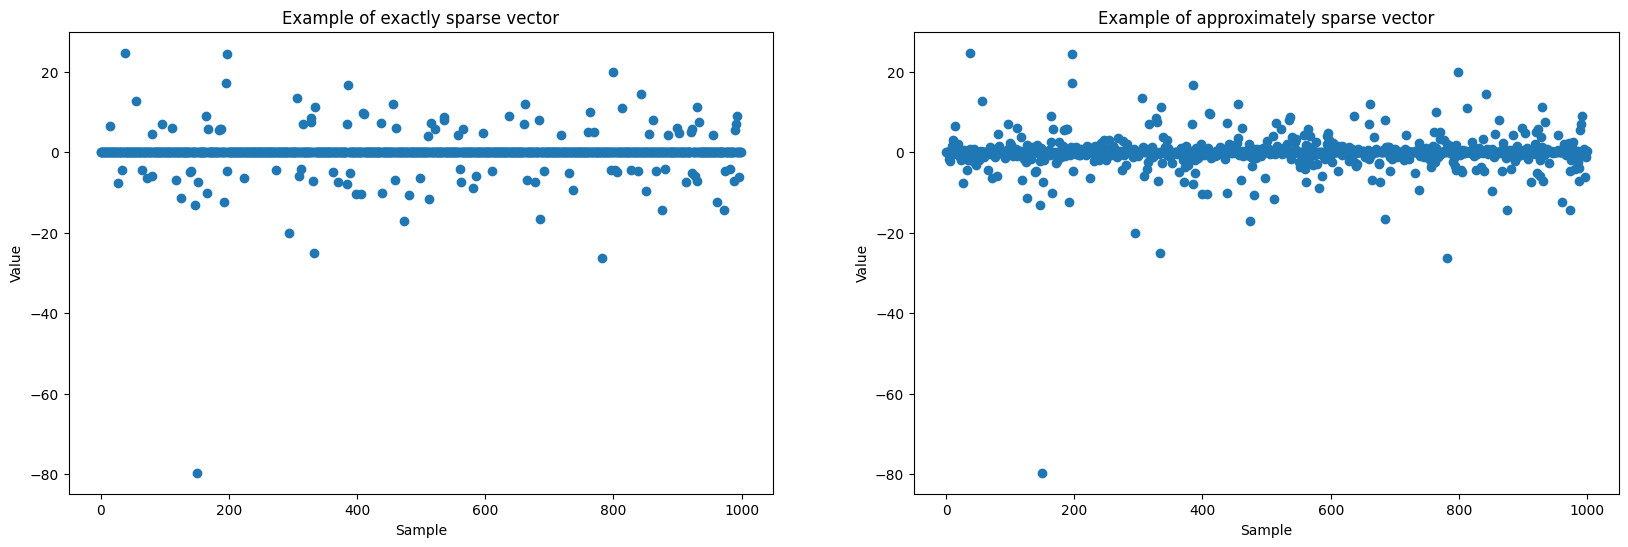

In [95]:
power = 3
approx_sparse = np.random.randn(1000)**power
exact_sparse = approx_sparse*(np.abs(approx_sparse)>4)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(exact_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of exactly sparse vector');

fig.add_subplot(1,2,2)
plt.plot(approx_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of approximately sparse vector');

What is the difference between an exactly and an approximately sparse signal? Recall the two corresponding definitions.

A sign is considered exactly sparse if only a small amount of elements are non-zeros. Another way to express this definition is by the relationship $\|s\|_0 = k \ll t$, with the pseudo-norm $\|\cdot\|_0$ being the cardinal of the support of $s$.


On the other hand, an approximately sparse signal is a signal that can be well-approximated by a sparse signal. This means that although most of its coefficients may be non-zero, most of the signal's energy is concentrated in a small number of large-magnitude coefficients. The remaining coefficients are small and can be neglected with minimal loss. Another way to express this definition is by stating that a signal $s$ is approximately k-sparse if it is close (in some norm, e.g. $\ell_2$) to a signal $\tilde{s}$ such that $\|\tilde{s}\|_0 = k \ll t$.


Now let's start to look at some mixtures and to try to geometrically interpret the impact of the mixing.

First, generate a simulated source S matrix. Plot the corresponding scatter plot. Interpret the shape of the scatter plot you obtain.

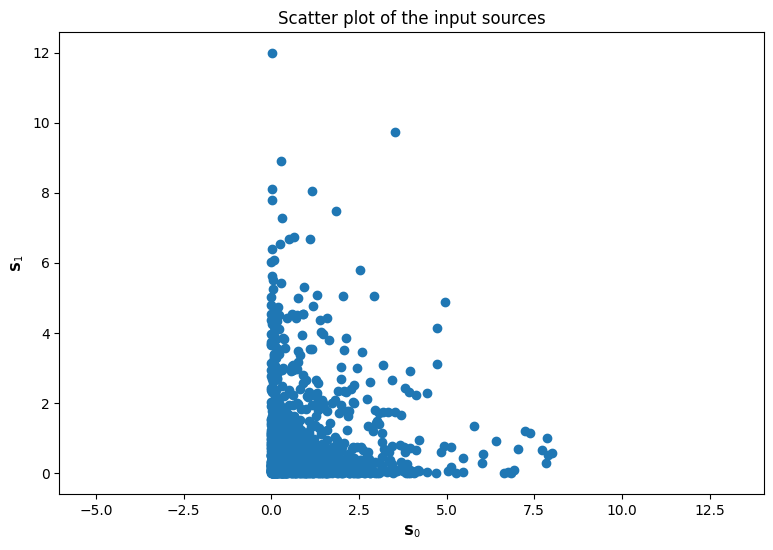

In [96]:
n = 2         # number of sources
t = 1024      # number of samples
noise_level = 80 # noise level, in dB
power = 2 # power exponent used in the source generation



# TO DO : generate a simulated source S matrix.
# S will be of dimensions n x t.
# Each of the n sources (i.e. lines of S) will follow the approximately sparse
# law we used above.
S = np.random.randn(n, t) ** power

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

In [97]:
# Here, we generate a mixture matrix (dimensions m x t) from the sources in S
m = 4         # number of observations

A = np.random.randn(m,n)
X = A@S

noise_level = 120

# To be more realistic, we add some noise to the mixing.
# Mixtures with SNR > 120 dB can be considered as noiseless for most applications.
if noise_level < 120:
    #--- Add noise
    N = np.random.randn(m,t)
    N = 10.**(-noise_level/20.)*np.linalg.norm(X)/np.linalg.norm(N)*N
    X = X + N

Plot the scatter plot of X. What do you see ?

**Answer:** The scatter plot shows observations concentrated along two main directions. This pattern implies that, as expected, most of the data points are linear combinations of a small number of dominant components.

What do the directions of the lines you observe correspond ?

**Answer:**
These directions correspond to the columns of matrix A, representing the signatures or spatial directions of the individual sources. Since the sources are approximately sparse, the observations often align closely to one column of A at a time.


Try several A matrices, noise_values and powers. Any comment?

**Answer:**
Changing A rotates or skews the scatter pattern, for the reason explained in the previous answer.

Increasing noise spreads the points around these directions, making them less identifiable.

Increasing the power makes the sources more sparse, as small signs get smaller and larger signs are expanded. It is interesting to notice that when using even values for the power the distribution gets assymetric. This is expected, as the signs get positive.

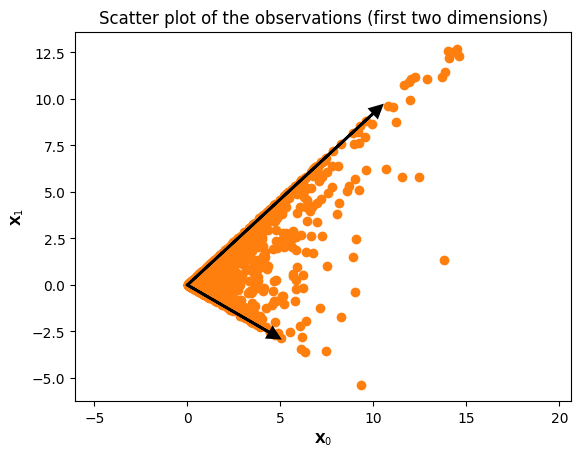

In [98]:
plt.title('Scatter plot of the observations (first two dimensions)')
vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

**II - Performing non-blind source separation**

**1) Data generation**

Before going into blind source separation, in which we want to find physical **A** and **S** matrices such that **X = AS + N**, let us first consider the simpler setting in which we know **A** and want to recover **S**.
We will consider the noisy mixture of two sine signals. The methodology extends to more complex datasets.

N.B. : unmixing two sinus signal could be done much more easily than using the algorithms we saw during the class. Nevertheless, focusing on such synthetic data enables an easy visualization. The principle readily extend to more complex datasets, such as images.

(-25.0, 25.0)

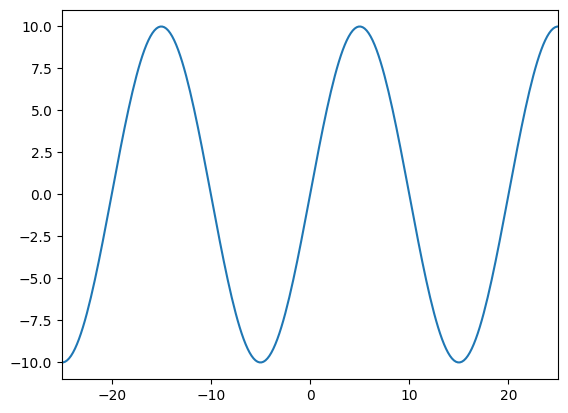

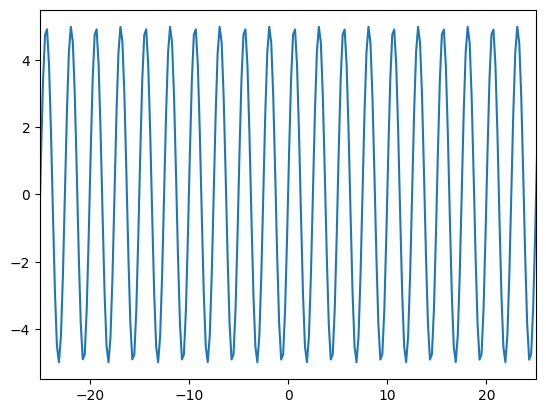

In [99]:
# Source generation
t = 10000
x_abs = np.linspace(-1000,1000,t)

S = np.zeros((2,t))
S[0,:] = 10*np.sin(2*np.pi*0.05*x_abs)
S[1,:] = 5*np.sin(2*np.pi*0.4*x_abs)

plt.figure(),plt.plot(x_abs,S[0,:])
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S[1,:])
plt.xlim([-25,25])

Here, we will transform the sources signals S into the DCT domain.

What is the objective of using the DCT?

**Answer:**
The DCT is a transform that represents a signal as a sum of cosine functions. One can notice that, for real and even functions, the fourier transform and DCT yeld the same results. In the context of this TP, condensation of information is the primary reason for this procedure. Interestingly, one can also interpret the DCT as a projection of the signal to a domain where it is sparse.




Plot the above DCT and justify what you see. Pay attention to the labeling of the x-axis. Try with sines of various frequencies.

(0.0, 0.5)

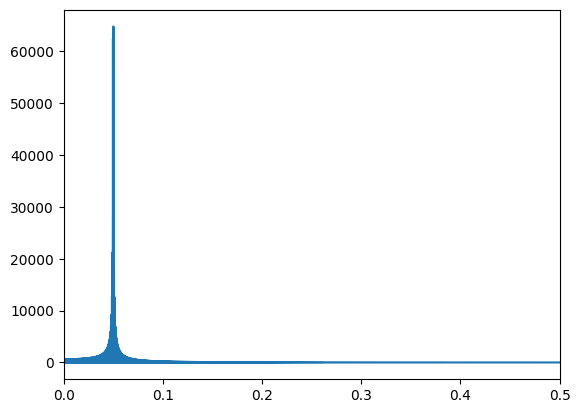

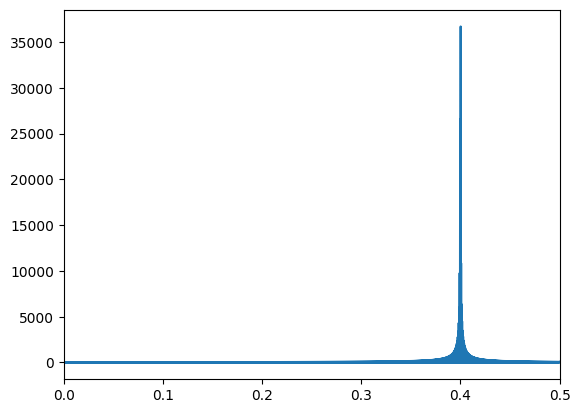

In [100]:
# Transformation into the DCT domain
Sf = sff.dct(S)

freq = np.arange(t) / (2 * (x_abs[-1] - x_abs[0]))

plt.figure(),plt.plot(freq,np.abs(Sf[0,:]))
plt.xlim(0, 0.5)
plt.figure(),plt.plot(freq,np.abs(Sf[1,:]))
plt.xlim(0, 0.5)


Data generation : now, we will create a mixture X = AS + N.

Plot the mixtures. Explain what you see.

**Answer:**
As expected, the DCT of x has peaks at the 0.05 and 0.4, the frequencies of the original signals. Naturally, as the transform is calculated numerically, the peaks are not perfect impulses. Moreover, the added noise also distortes the final transform.


Compute the DCT of X. Plot it and explain. Which caracteristic of the DCT will we use to recover the sources?

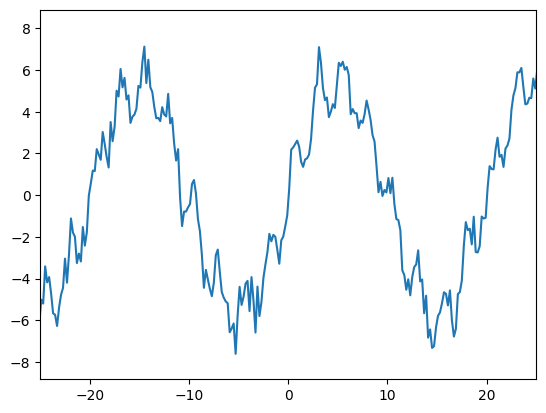

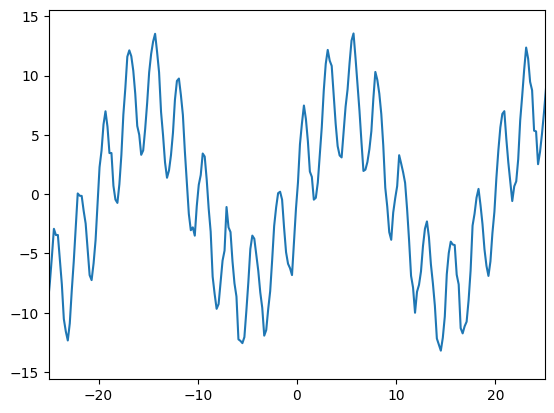

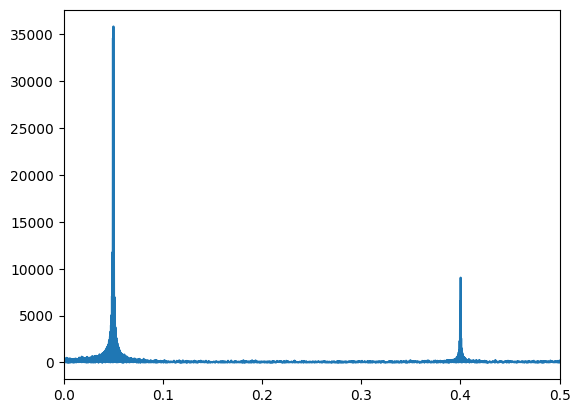

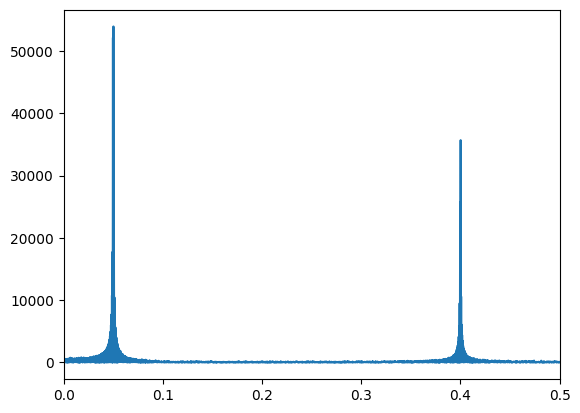

In [101]:
A = np.array([[0.5547002 , 0.24253563],
       [0.83205029, 0.9701425 ]]) # You can try other A values, but the columns must have a unitary norm.

X = A@S
X = X + 0.5*np.random.randn(np.shape(X)[0],np.shape(X)[1])# You can try other noise values

Xf = sff.dct(X)



plt.figure(), plt.plot(x_abs, X[0, :])
plt.xlim([-25, 25])

plt.figure(), plt.plot(x_abs, X[1, :])
plt.xlim([-25, 25])

# DCT of noisy signals
plt.figure(), plt.plot(freq, np.abs(Xf[0, :]))
plt.xlim(0, 0.5)

plt.figure(), plt.plot(freq, np.abs(Xf[1, :]))
plt.xlim(0, 0.5)

plt.show()



**2) Source separation**

Now that we generated observations from simulated sources, we will focus on the source separation problem: recovering the sources from the observations (and the knowledge of A, since we are here in the non-blind setting).

To do that, we propose here to solve the source separation problem using a sparsity constraint on the sources. The cost function will then be minimized using the ISTA algorithm.

First, write the cost function we want to minimize to perform non-blind sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?

**Answer:**
The cost function is defined by the following relation

$$
\min_{A \in \mathbb{R}^{m \times n},\, S \in \mathbb{R}^{m \times n}} \frac{1}{2} \|X - AS\|_F^2 + \lambda \|S\|_1
$$

Where:

- $\frac{1}{2} \|X - AS\|_F^2$ is called the Data Fidelity Term, that penalises A estimations that do not yield resuls in accordance with the data X. This function is smooth and convex.


- $\lambda \|S\|_1$ is the Sparsity Term, that enforces a smoothening in the final result. One can notice it is the usual L1 Regularization. This function, although not smooth, is still convex.



Compute the gradient along the S variable of the data-fidelity term.

**Answer:**
$$
\nabla_S \left( \frac{1}{2} \|X - AS\|_F^2 \right) = -A^T (X - AS)
$$

Recall what the proximal operator of the l1-norm is.



**Answer:**

The proximal operator of the L1 norm is Is given by:

$$
\left( \text{prox}_{\lambda \|\cdot\|_1}(v) \right)_i =
\begin{cases}
v_i - \lambda & \text{if } v_i > \lambda \\
0 & \text{if } |v_i| \leq \lambda \\
v_i + \lambda & \text{if } v_i < -\lambda
\end{cases}
$$

In [102]:
# TO DO: implement the proximal operator of the l1-norm in the above function:
def prox_l1(S_est,thrd):
 # To complete
  return np.sign(S_est) * np.maximum(np.abs(S_est) - thrd, 0)



Explain the main idea of the ISTA algorithm. Then, implement it.


**Answer:**
The ISTA algorythm is used to solve problems of optimization when the function being optimized is nonsmooth, but has a smooth portion. This is preciselly the case when dealing with a Data Attachment term (smooth) and a L1 regularization.

It solves the issue by starting each iteration applying a gradient descent to using the gradient of the data attachment term (Gradient Step) followed by applying the soft-tresholding (Proximal Step)

In [103]:
# TO DO: implement the ISTA algorithm to minimize the cost function you wrote in question II-2-1.
def ISTA(X,A = np.eye(2),n=2,lamb=0,nbIt = 100):
    S_est = np.zeros((A.shape[1], X.shape[1]))
    gamma = 0.9 / np.linalg.norm(A.T @ A)
    for index in range(nbIt):
        S_est = prox_l1(S_est - gamma * (A.T @ (A @ S_est - X)), lamb)
    return S_est

It's now time to play with the code : launch the ISTA algorithm and look at the results.

Try various lamb values. What is the minimum value you should no go below? What is the issue with choosing too big values?

**Answer:**
Naturally, lamb should not be lower than zero (lamb = 0 implies no regularization).
On the other hand, if lamb is too large the algorithm will excessively prioritize sparsity, not giving sufficient weight to Data Fidelity.

In [104]:
# S_estf = ISTA(Xf,A = A,n=2,lamb=1000,nbIt = 1000)



Plot the estimated sources in the DCT domain. What kind of sparsity to they exhibit? Why?

**Answer:**

 The signals are approximately sparse, concentrated in the original frequencies of the original frequencies of the signals. As previously explained, this is the expected behavior

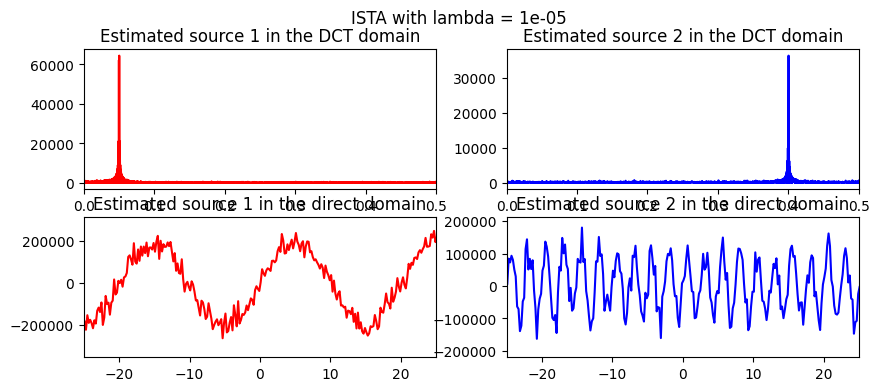

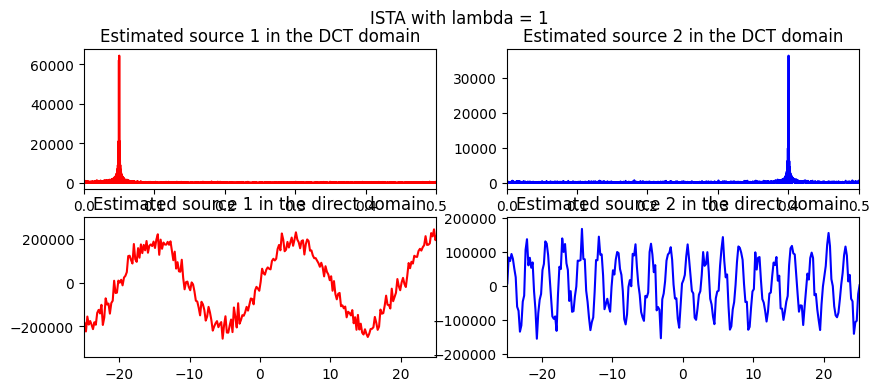

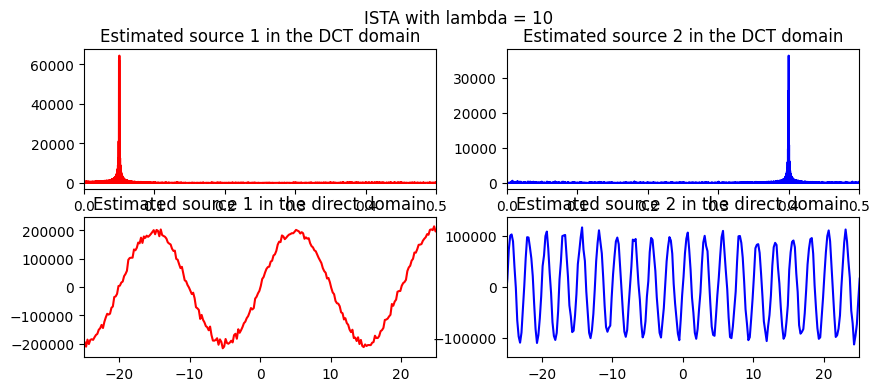

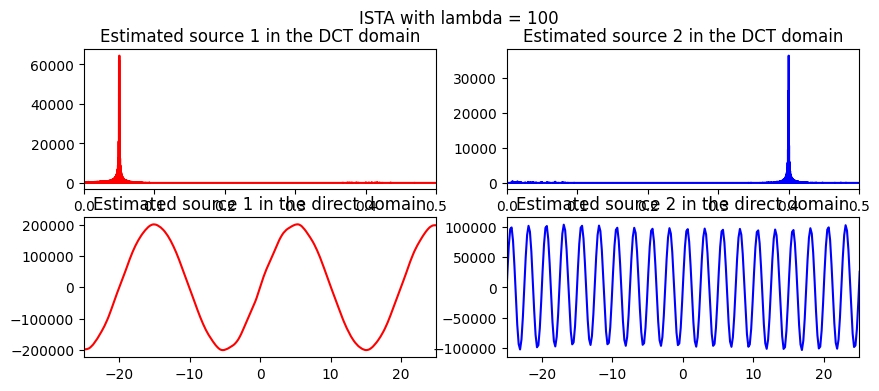

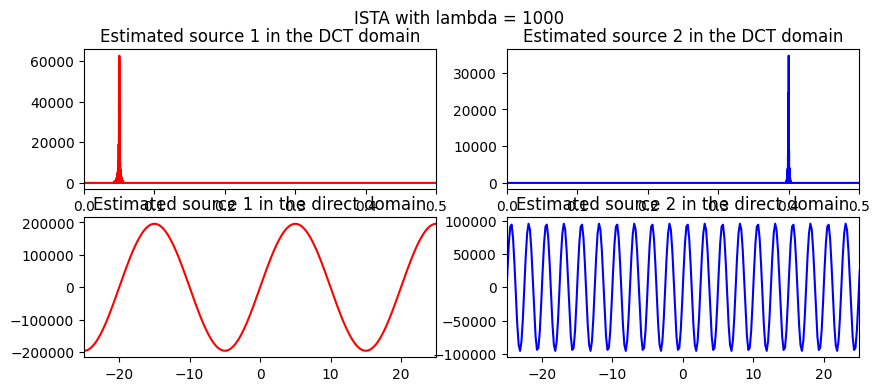

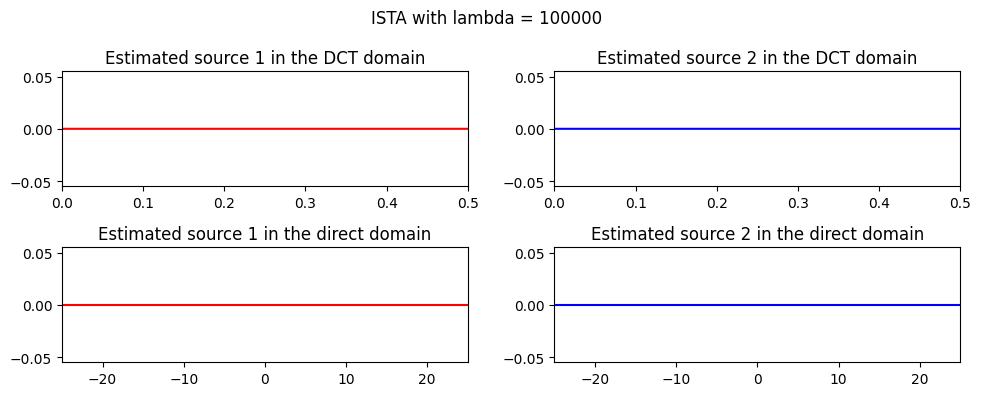

In [105]:
lbd = [0.00001, 1, 10, 100, 1000, 100000]

for i, lamb in enumerate(lbd):

    S_estf = ISTA(Xf, A=A, n=2, lamb=lamb, nbIt = 1000)
    fig, ax = plt.subplots(2, 2, figsize=(10, 4))
    fig.suptitle('ISTA with lambda = ' + str(lamb))

    ax[0, 0].plot(freq, abs(S_estf[0,:]), c='r')
    ax[0, 0].set_xlim([0, 0.5])
    ax[0, 0].set_title('Estimated source 1 in the DCT domain')

    ax[0, 1].plot(freq, abs(S_estf[1,:]), c='b')
    ax[0, 1].set_xlim([0, 0.5])
    ax[0, 1].set_title('Estimated source 2 in the DCT domain')
    S_est = sff.idct(S_estf)

    ax[1, 0].plot(x_abs, S_est[0,:], c='r')
    ax[1, 0].set_xlim([-25,25])
    ax[1, 0].set_title('Estimated source 1 in the direct domain')

    ax[1, 1].plot(x_abs, S_est[1,:], c='b')
    ax[1, 1].set_xlim([-25,25])
    ax[1, 1].set_title('Estimated source 2 in the direct domain')


plt.tight_layout()
plt.show()

Transform the sources back in the direct domain. Plot them. What do you see? Explain the differences with the original sources. Conclude.

**Answer:**
The results are extremely close to the original signal. Any potential difference is due to numerical issues.

<ipython-input-106-a0a1a673bd37>:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(x_abs, S_dir[0] * S[0].max() / S_dir[0].max())


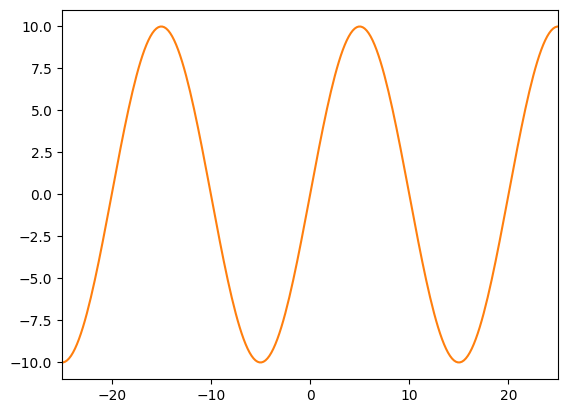

<ipython-input-106-a0a1a673bd37>:10: RuntimeWarning: invalid value encountered in divide
  plt.plot(x_abs, S_dir[1] * S[1].max() / S_dir[1].max())


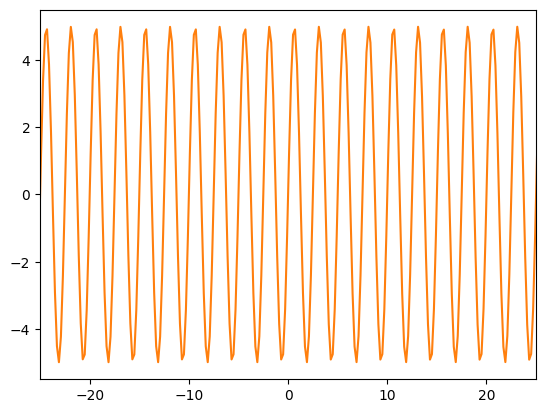

In [106]:
S_dir = sff.idct(S_estf)

plt.figure()
plt.plot(x_abs, S_dir[0] * S[0].max() / S_dir[0].max())
plt.plot(x_abs, S[0])
plt.xlim([-25, 25])
plt.show()

plt.figure()
plt.plot(x_abs, S_dir[1] * S[1].max() / S_dir[1].max())
plt.plot(x_abs, S[1])
plt.xlim([-25, 25])
plt.show()

**III - Blind Source Separation : PALM**

Let's now delve into the core problem : *blind* source separation, in which **A** is unknown. To leverage sparsity, we will use the PALM algorithm.

Thoughout this whole section, we will re-use the same synthetic data as above (i.e., the one generated in II-1).

Write the cost function we want to minimize to perform *blind* sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?


**Answer:**
The cost function is defined by the following relation

$$
\min_{A \in \mathbb{R}^{m \times n},\, S \in \mathbb{R}^{m \times n}} \frac{1}{2} \|X - AS\|_F^2 + \lambda \|S\|_1 + \iota_{\{i \in [1,n]; \|a_{i, \cdot}\|_2^2 \leq 1\}}(A)
$$

Where:

- $\frac{1}{2} \|X - AS\|_F^2$ is called the Data Fidelity Term, that penalises A estimations that do not yield resuls in accordance with the data X. This function is smooth and convex.

- $\lambda \|S\|_1$ is the Sparsity Term, that enforces a smoothening in the final result. One can notice it is the usual L1 Regularization. This function, although not smooth, is still convex.

- $\iota_{\{i \in [1,n]; \|a_{i, \cdot}\|_2^2 \leq 1\}}(A)$ is the Oblique Constraint, that enforces each column of $A$ to have unit norm. This avoids scale ambiguity between $A$ and $S$, which would otherwise make the problem ill-posed. Note that this term is not convex.


Recall what the gradient of the data fidelity term over A is.

**Answer:**

$$
\nabla_A \left( \frac{1}{2} \|X - AS\|_F^2 \right) = - (X - AS) S^T
$$


Compte the proximal operator of the oblique constraint. Implement it.

**Answer:**
$$
\text{prox}_{\iota_{\{i \in [1,n]; \|a_{\cdot, j}\|_2^2 \leq 1\}}}(A) =
\begin{cases}
\frac{a_{\cdot, j}}{\|a_{\cdot, j}\|_2} & \text{if } \|a_{\cdot, j}\|_2 > 1 \\
a_{\cdot, j} & \text{otherwise}
\end{cases}
$$


In [118]:
def prox_oblique(A):
   # TO DO
    for j in range(A.shape[1]):
      if np.linalg.norm(A[:, j]) > 1:
        A[:, j] /= np.linalg.norm(A[:, j])
    return A

Implement the PALM algorithm to minimize the cost function you wrote in III-1).

In [119]:

def PALM(X,n=2,lamb=0,nbIt = 100):

   # TO DO
    A_est = np.random.randn(X.shape[0], n)
    S_est = np.random.randn(n, X.shape[1])
    gamma_S = 0.9 / np.linalg.norm(A_est.T @ A_est)
    for _ in range(nbIt):
        S_est = prox_l1(S_est + 0.9/np.linalg.norm(A_est.T @ A_est) * A_est.T @ (X - A_est @ S_est), lamb)
        A_est = prox_oblique(A_est + 0.9/np.linalg.norm(S_est @ S_est.T) * (X - A_est @ S_est) @ S_est.T)
    return A_est, S_est

Launch the PALM algorithm to retrieve both A and S from X. Plot your results. How good is the separation? The separation quality is usually well evaluated comparing the true and estimated A matrices.

**Answer:**
As evident by comparing both matrices, the result is very good.

In [120]:
A_est, S_estf = PALM(Xf, n=2, lamb=1000, nbIt=1000)
print("Matrix A:\n", A)
print("Matrix A_est:\n", A_est)


Matrix A:
 [[0.5547002  0.24253563]
 [0.83205029 0.9701425 ]]
Matrix A_est:
 [[0.55330764 0.24444938]
 [0.83297698 0.96966205]]


(0.0, 0.5)

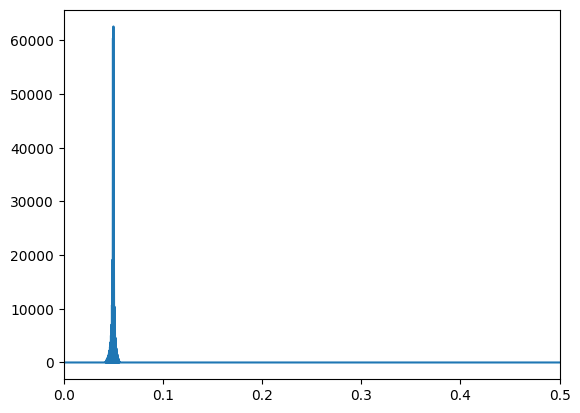

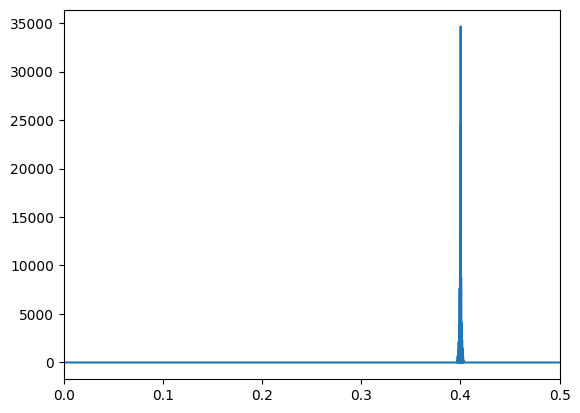

In [121]:
plt.figure(),plt.plot(freq,np.abs(S_estf[0,:]))
plt.xlim(0, 0.5)
plt.figure(),plt.plot(freq,np.abs(S_estf[1,:]))
plt.xlim(0, 0.5)


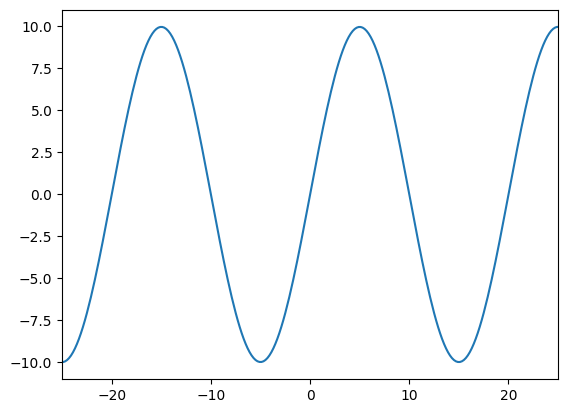

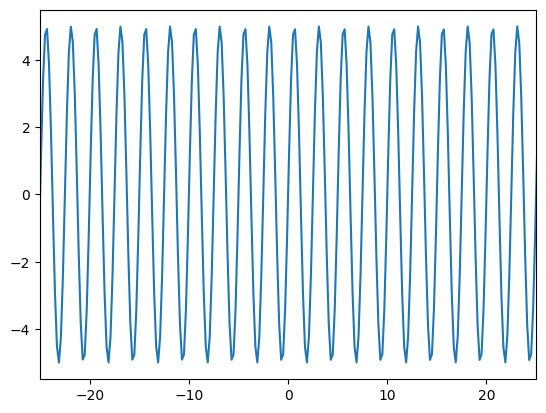

In [122]:
S_dir = sff.idct(S_estf)

plt.figure()
plt.plot(x_abs, S_dir[0] * S[0].max() / S_dir[0].max())
plt.xlim([-25, 25])
plt.show()

plt.figure()
plt.plot(x_abs, S_dir[1] * S[1].max() / S_dir[1].max())
plt.xlim([-25, 25])
plt.show()